# InterAMPM Experiment Results

**Last Modified**: Aug 10, 2025

In this notebook, we summarize and visualize the results from `interAMPM` experiment. The training and testing data splits are created randomly for this experiment. We conduct hyperparameter tuning and look at the prediction results f the best performing model.

In [1]:
# System & OS

import sys
import os
sys.path.append('../')
sys.path.append('../../')
import numpy as np
import pandas as pd

# Torch
import torch
from torch.utils.data import TensorDataset, DataLoader

# Script imports
from src.utils.io import (get_results_path,
                          get_metadata_path,
                          get_video_labels_path,
                          get_audio_labels_path,
                            get_matched_data_path,
                            get_matched_metadata_path)

from src.utils.plot import(multi_label_predictions)

from src.utils.data import (setup_data_objects,
                            setup_multilabel_dataloaders,
                            )

from src.utils.conformal import validate

from config.settings import (COLLAPSE_BEHAVIORS_MAPPING,
                             BEHAVIORS,
                             id_mapping)

from src.data_prep.data_prep_utils import combined_annotations

# Plotting
import matplotlib.pyplot as plt

# Sklearn
from sklearn.preprocessing import LabelEncoder

device = torch.device(f"cuda:0" if torch.cuda.is_available() else "cpu")

In [2]:
# Graphing Parameters
import matplotlib as mpl
mpl.rcParams['lines.markersize'] = 12
mpl.rcParams['lines.linewidth'] = 2
mpl.rcParams['xtick.labelsize'] = 30
mpl.rcParams['ytick.labelsize'] = 30
mpl.rcParams["axes.labelsize"] = 40
mpl.rcParams['legend.fontsize'] = 40
mpl.rcParams['axes.titlesize'] = 45
mpl.rcParams['text.usetex'] = False
# plt.rcParams['font.family'] = 'serif'

In [3]:
label_encoder = LabelEncoder()
label_encoder.fit(BEHAVIORS)
experiment_name = 'interAMPM'

#### Hyperparameter Tuning

In [4]:
# you need to run 'scrpts/interyear.sh' for produce the hyperparameter finetuning plots.

channels, layers, kernel_sizes, seeds = [16, 32, 64], [2, 3, 4, 5], [3, 5], [0, 1, 2, 3, 4, 5]
accuracies = np.zeros((len(channels), len(layers), len(kernel_sizes), len(seeds)))
f1_scores = np.zeros((len(channels), len(layers), len(kernel_sizes), len(seeds)))
colors = ['brown', 'goldenrod', 'green']


for i,channel in enumerate(channels):
    for j,layer in enumerate(layers):
        for k,k_size in enumerate(kernel_sizes):
            for l, seed in enumerate(seeds):
                dir = get_results_path(experiment_name, layer, channel, k_size, 0.0, seed)
                accuracies[i,j,k,l] = multi_label_predictions(dir, label_encoder, split='val', plot_confusion=False, return_accuracy=True)
                f1_scores[i,j,k,l] = multi_label_predictions(dir, label_encoder, split='val', plot_confusion=False, return_f1=True)

fig, axs = plt.subplots(1,2, figsize=(14, 6), sharey=True)
for i in range(len(kernel_sizes)):
    for c in range(len(channels)):
        if i ==0:
            axs[i].plot(layers, np.mean(accuracies, -1)[c,:,i], label=f'Channels - {channels[c]}', markersize=15, marker='s', color=colors[c])
            axs[i].set_ylabel('Average accuracy')
        else:
            axs[i].plot(layers, np.mean(accuracies, -1)[c,:,i], markersize=15, marker='s', color=colors[c])
        
        for l in range(len(seeds)):
            axs[i].plot(layers, accuracies[c,:,i,l], color=colors[c], alpha=0.1, linestyle='--')

        axs[i].set_title(f'Kernel size - {kernel_sizes[i]}')
    axs[i].set_xlabel('Number of CNN layers')
fig.legend(loc='center', bbox_to_anchor=(.5, -0.07), ncol=3)
plt.tight_layout()
plt.show()

fig, axs = plt.subplots(1,2, figsize=(14,6), sharey=True)
for i in range(len(kernel_sizes)):
    for c in range(len(channels)):
        if i ==0:
            axs[i].plot(layers, np.mean(f1_scores, -1)[c,:,i], label=f'Channels - {channels[c]}', markersize=15, marker='s', color=colors[c])
            axs[i].set_ylabel('Average F1 score')

        else:
            axs[i].plot(layers, np.mean(f1_scores, -1)[c,:,i], markersize=15, marker='s', color=colors[c])

        for l in range(len(seeds)):
            axs[i].plot(layers, f1_scores[c,:,i,l], color=colors[c], alpha=0.1, linestyle='--')

        axs[i].set_title(f'Kernel size - {kernel_sizes[i]}')
    axs[i].set_xlabel('Number of CNN layers')
fig.legend(loc='center', bbox_to_anchor=(.5, -0.07), ncol=3)
plt.tight_layout()
plt.savefig(f'../figures/{experiment_name}-hyperparameter_tuning.pdf', format="pdf", bbox_inches="tight")
plt.show()

FileNotFoundError: [Errno 2] No such file or directory: '/home/medhaaga/AWD-Biologging/results/predictions/interAMPM/conv_layers_2/n_channels_16/kernel_size_3/theta_0.0/seed_0/val_true_classes.npy'

In [6]:
# you need to run 'scrpts/interyear.sh' for produce the hyperparameter finetuning plots.

thetas = 0.1*np.arange(11)
seeds = [0, 1, 2, 3, 4, 5]
colors = ['brown', 'goldenrod', 'green']

precisions = np.zeros((len(thetas), len(seeds)))
recalls = np.zeros((len(thetas), len(seeds)))
f1scores = np.zeros((len(thetas), len(seeds)))

for i, theta in enumerate(thetas):
    for j, seed in enumerate(seeds):
        dir = get_results_path(experiment_name, 3, 64, 5, np.round(theta,1), seed)
        precisions[i, j] = multi_label_predictions(dir, label_encoder, split='val', plot_confusion=False, return_precision=True)
        recalls[i, j] = multi_label_predictions(dir, label_encoder, split='val', plot_confusion=False, return_recall=True)
        f1scores[i, j] = multi_label_predictions(dir, label_encoder, split='val', plot_confusion=False, return_f1=True)


plt.figure(figsize=(9,8))
for i in range(len(seeds)):
    plt.plot(thetas, precisions[:, i], color=colors[0],  alpha=0.1, linestyle='--')
    plt.plot(thetas, recalls[:, i], color=colors[1], alpha=0.1, linestyle='--')
    plt.plot(thetas, f1scores[:, i], color=colors[2], alpha=0.1, linestyle='--')
plt.plot(thetas, np.mean(precisions, axis=1), color=colors[0], label='Precision', markersize=15, linewidth=2, marker='s',)
plt.plot(thetas, np.mean(recalls, axis=1), color=colors[1], label='Recall', markersize=15, linewidth=2, marker='o',)
plt.plot(thetas, np.mean(f1scores, axis=1), color=colors[2], label='F1 Score', markersize=15, linewidth=2, marker='^',)
plt.axvline(0.1, color='grey', alpha=0.5, linestyle='--')
plt.xlabel(r'$\theta$', labelpad=20)
plt.ylabel('Evaluation Metric', labelpad=20)
plt.legend(loc='center', bbox_to_anchor=(.5, -0.3), ncol=3)
# plt.tight_layout()
plt.savefig(f'../figures/{experiment_name}-theta_tuning.pdf', format="pdf", bbox_inches="tight")
plt.show()

FileNotFoundError: [Errno 2] No such file or directory: '/home/medhaaga/AWD-Biologging/results/predictions/interAMPM/conv_layers_3/n_channels_64/kernel_size_5/theta_0.9/seed_0/val_true_classes.npy'

<Figure size 640x480 with 0 Axes>

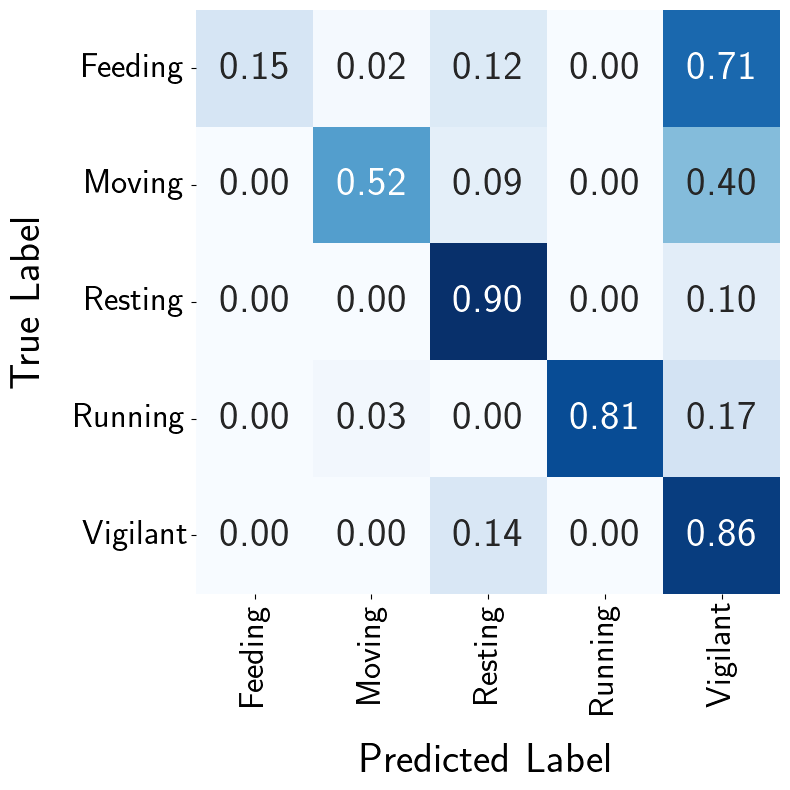

In [5]:
dir = get_results_path(experiment_name, 3, 64, 5, 0.0, 50)
plot_path = os.path.join(get_figures_dir(), f'{experiment_name}-confusion_mat_theta0.0.png')
multi_label_predictions(dir, label_encoder, split='test', plot_confusion=True, return_accuracy=False, plot_path=plot_path)

In [ ]:
theta_star = 0.3

<Figure size 640x480 with 0 Axes>

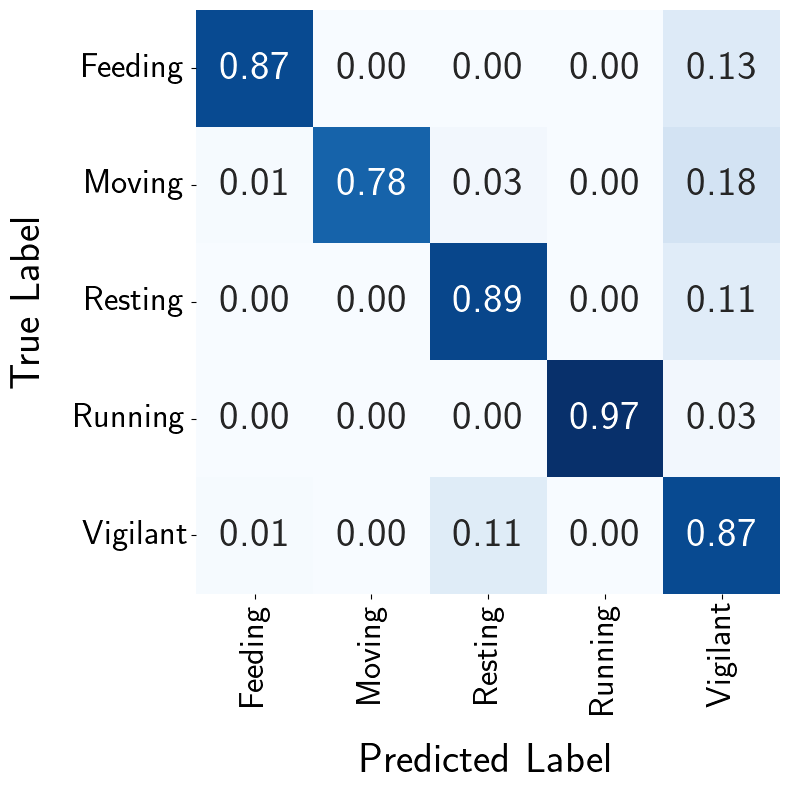

In [ ]:
dir = get_results_path(experiment_name, 5, 64, 5, theta_star, 0)
multi_label_predictions(dir, label_encoder, split='test', plot_confusion=True, return_accuracy=False, plot_path=f'../figures/{experiment_name}-confusion_mat_theta{theta_star}.pdf')

In [7]:
print('VALIDATION PRECISION SCORE')
print('---------------------')
precision = np.round(multi_label_predictions(dir, label_encoder, split='val', plot_confusion=False, return_precision=True, average='macro'), 3)
print(f'Average precision: {precision}')
print(pd.DataFrame({'behavior': BEHAVIORS, 'precision': np.round(multi_label_predictions(dir, label_encoder, split='val', plot_confusion=False, return_precision=True, average=None), 3)}))

print('VALIDATION RECALL SCORE')
print('---------------------')
recall = np.round(multi_label_predictions(dir, label_encoder, split='val', plot_confusion=False, return_recall=True, average='macro'), 3)
print(f'Average recall: {recall}')
print(pd.DataFrame({'behavior': BEHAVIORS, 'recall': np.round(multi_label_predictions(dir, label_encoder, split='val', plot_confusion=False, return_recall=True, average=None), 3)}))

print('VALIDATION F1 SCORE')
print('---------------------')
f1 = np.round(multi_label_predictions(dir, label_encoder, split='val', plot_confusion=False, return_f1=True, average='macro'), 3)
print(f'Average F1 score: {f1}')
print(pd.DataFrame({'behavior': BEHAVIORS, 'f1 score': np.round(multi_label_predictions(dir, label_encoder, split='val', plot_confusion=False, return_f1=True, average=None), 3)}))

print('VALIDATION ACCURACY')
print('---------------------')
accuracy = np.round(multi_label_predictions(dir, label_encoder, split='val', plot_confusion=False, return_accuracy=True), 3)
print(f'Accuracy: {accuracy}')

VALIDATION PRECISION SCORE
---------------------


FileNotFoundError: [Errno 2] No such file or directory: '/home/medhaaga/AWD-Biologging/results/predictions/interAMPM/conv_layers_3/n_channels_64/kernel_size_5/theta_0.9/seed_0/val_true_classes.npy'

In [13]:
print('TEST PRECISION SCORE')
print('---------------------')
precision = np.round(multi_label_predictions(dir, label_encoder, split='test', plot_confusion=False, return_precision=True, average='macro'), 3)
print(f'Average precision: {precision}')
print(pd.DataFrame({'behavior': BEHAVIORS, 'precision': np.round(multi_label_predictions(dir, label_encoder, split='test', plot_confusion=False, return_precision=True, average=None), 3)}))

print('TEST RECALL SCORE')
print('---------------------')
recall = np.round(multi_label_predictions(dir, label_encoder, split='test', plot_confusion=False, return_recall=True, average='macro'), 3)
print(f'Average recall: {recall}')
print(pd.DataFrame({'behavior': BEHAVIORS, 'recall': np.round(multi_label_predictions(dir, label_encoder, split='test', plot_confusion=False, return_recall=True, average=None), 3)}))

print('TEST F1 SCORE')
print('---------------------')
f1 = np.round(multi_label_predictions(dir, label_encoder, split='test', plot_confusion=False, return_f1=True, average='macro'), 3)
print(f'Average F1 score: {f1}')
print(pd.DataFrame({'behavior': BEHAVIORS, 'f1 score': np.round(multi_label_predictions(dir, label_encoder, split='test', plot_confusion=False, return_f1=True, average=None), 3)}))

print('TEST ACCURACY')
print('---------------------')
accuracy = np.round(multi_label_predictions(dir, label_encoder, split='test', plot_confusion=False, return_accuracy=True), 3)
print(f'Accuracy: {accuracy}')

TEST PRECISION SCORE
---------------------
Average precision: 0.905
   behavior  precision
0   Feeding      0.898
1   Resting      0.979
2    Moving      0.952
3   Running      0.972
4  Vigilant      0.724
TEST RECALL SCORE
---------------------
Average recall: 0.878
   behavior  recall
0   Feeding   0.874
1   Resting   0.782
2    Moving   0.889
3   Running   0.972
4  Vigilant   0.874
TEST F1 SCORE
---------------------
Average F1 score: 0.888
   behavior  f1 score
0   Feeding     0.886
1   Resting     0.869
2    Moving     0.920
3   Running     0.972
4  Vigilant     0.792
TEST ACCURACY
---------------------
Accuracy: 0.881


#### Conformal Prediction

In [8]:
class Arguments:
        def __init__(self, experiment_name, 
                     batch_size, 
                     window_duration_percentile,
                     train_test_split,
                     train_val_split,
                     padding, 
                     theta,
                     filter_type,
                     cutoff_frequency,
                     cutoff_order,
                     normalization,
                     match,
                     min_duration):
                self.experiment_name = experiment_name
                self.batch_size = batch_size
                self.window_duration_percentile = window_duration_percentile
                self.train_test_split = train_test_split
                self.train_val_split = train_val_split
                self.padding = padding
                self.theta = theta
                self.filter_type = filter_type
                self.cutoff_frequency = cutoff_frequency
                self.cutoff_order = cutoff_order
                self.normalization = normalization
                self.match = match
                self.min_duration = min_duration


args = Arguments(experiment_name=experiment_name, 
                batch_size=64, 
                window_duration_percentile=50, 
                train_test_split=0.2, 
                train_val_split=0.2, 
                padding='repeat', 
                theta=0.8, 
                filter_type='high', 
                cutoff_frequency=0, 
                cutoff_order=5, 
                normalization=0,
                match=0,
                min_duration=1.0)

In [9]:
metadata = pd.read_csv(get_metadata_path()) # load metadata
all_annotations = combined_annotations(video_path=get_video_labels_path(),
                                        audio_path=get_audio_labels_path(),
                                        id_mapping=id_mapping) # load annotations 

X_train, y_train, z_train, X_val, y_val, z_val, X_test, y_test, z_test, label_encoder = setup_data_objects(metadata, 
                                                                                                    all_annotations, 
                                                                                                    COLLAPSE_BEHAVIORS_MAPPING, 
                                                                                                    BEHAVIORS, 
                                                                                                    args, 
                                                                                                    reuse_behaviors=BEHAVIORS,
                                                                                                    acc_data_path=get_matched_data_path(), 
                                                                                                    acc_metadata_path=get_matched_metadata_path()) 
train_dataloader, val_dataloader, test_dataloader = setup_multilabel_dataloaders(X_train, y_train, X_val, y_val, X_test, y_test, args)

Using pre-matched acceleration-behavior pairs...
Total number of matched annotations: 6311
No overlaps. 
no. of train observations: 4764, no. of test observations: 1547

Matching annotations to acceleration snippets takes 3.699404 seconds
Creating fixed-duration windows takes 38.264989 seconds.

Time series duration window = 12.937


In [12]:
print(X_train.shape, X_val.shape, X_test.shape)


print("Class distribution of train set")
print('--------------------------------')
print(pd.DataFrame({'Behavior': label_encoder.inverse_transform(np.arange(5)), 'Proportion': np.unique(y_train, return_counts=True)[1]}))
print("")

print("Class distribution of validation set")
print('--------------------------------')
print(pd.DataFrame({'Behavior': label_encoder.inverse_transform(np.arange(5)), 'Proportion': np.unique(y_val, return_counts=True)[1]}))
print("")

print("Class distribution of test set")
print('--------------------------------')
print(pd.DataFrame({'Behavior': label_encoder.inverse_transform(np.arange(5)), 'Proportion': np.unique(y_test, return_counts=True)[1]}))
print("")


(13712, 3, 206) (3429, 3, 206) (6227, 3, 206)
Class distribution of train set
--------------------------------
   Behavior  Proportion
0   Feeding         246
1    Moving         402
2   Resting        9001
3   Running         119
4  Vigilant        3944

Class distribution of validation set
--------------------------------
   Behavior  Proportion
0   Feeding          61
1    Moving         100
2   Resting        2251
3   Running          30
4  Vigilant         987

Class distribution of test set
--------------------------------
   Behavior  Proportion
0   Feeding         182
1    Moving         234
2   Resting        4190
3   Running          36
4  Vigilant        1585



In [13]:
from src.utils.simulations import energy_distance, compute_features
import ot
from sklearn.preprocessing import StandardScaler


scaler = StandardScaler()
X_train_features = compute_features(X_train)
X_train_features = scaler.fit_transform(X_train_features)
X_test_features = compute_features(X_test)
X_test_features = scaler.transform(X_test_features)

ot_value = np.round(ot.sliced_wasserstein_distance(X_train_features, X_test_features, n_projections=100), 4)
energy_value = np.round(energy_distance(X_train_features, X_test_features), 4)
print(f"{'Sliced Wasserstein distance:':<15} {ot_value} | {'Energy distance:':<15} {energy_value}")

Sliced Wasserstein distance: 0.1176 | Energy distance: 0.0369



The true behavior is Feeding and the RAPS is ['Feeding' 'Vigilant'] with scores [0.63358843 0.26191816]

The true behavior is Moving and the RAPS is ['Vigilant' 'Moving'] with scores [0.5765266 0.3662522]

The true behavior is Resting and the RAPS is ['Resting'] with scores [0.9822934]


/tmp/ipykernel_1772734/4225343904.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cmodel = torch.load(os.path.join(dir, 'cmodel.pt'))


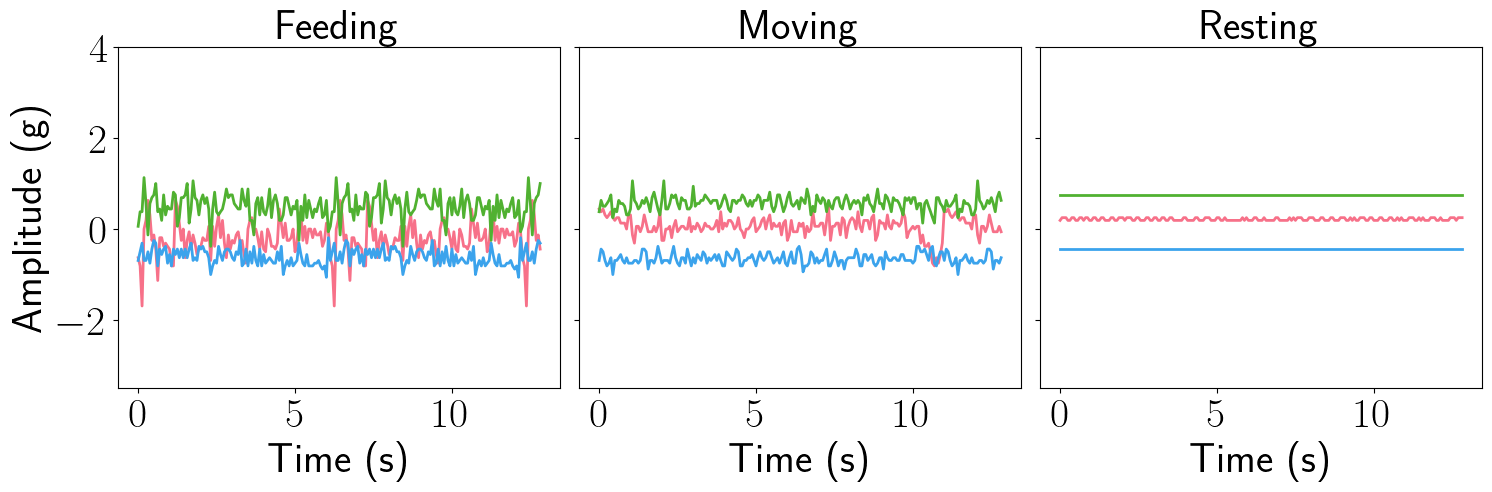

The true behavior is Running and the RAPS is ['Running'] with scores [0.94822574]
The true behavior is Vigilant and the RAPS is ['Vigilant'] with scores [0.9865501]


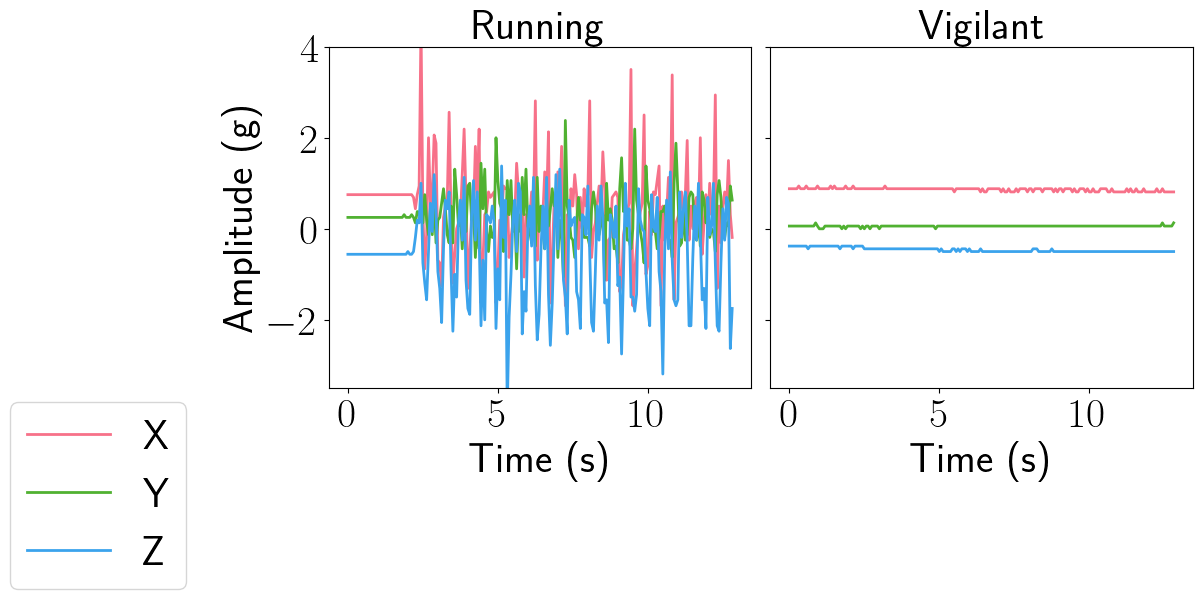

In [ ]:
# For example: the prediction sets for a random sample of 10 observations is:
np.random.seed(seed=4)
from scipy.special import softmax
cmodel = torch.load(os.path.join(dir, 'cmodel.pt'), weights_only=False)
cmodel = cmodel.to(device)
idx = [np.random.choice(np.where(y_test == i)[0]) for i in range(len(BEHAVIORS)) ]
# colors = sns.color_palette('husl', 3)
colors =  ['#9b2226', '#ee9b00', '#0a9396']
fig, axs = plt.subplots(1, 5, figsize=(25, 6), sharey=True)

for n,i in enumerate(idx):
    with torch.no_grad():
        acc, target = torch.tensor(X_test[i], dtype=torch.float32), label_encoder.inverse_transform([y_test[i]])[0]
        logits, set = cmodel(acc.unsqueeze(0).to(device))
        logits_numpy = logits.detach().cpu().numpy()
        scores = softmax(logits_numpy, axis=1)
    acc = acc.detach().cpu().numpy()
    axs[n].plot(np.arange(acc.shape[1])/16, acc[0], color=colors[0], label='X', linewidth=4)
    axs[n].plot(np.arange(acc.shape[1])/16, acc[1], color=colors[1], label='Y', linewidth=4)
    axs[n].plot(np.arange(acc.shape[1])/16, acc[2], color=colors[2], label='Z', linewidth=4)
    axs[n].set_title(target)
    axs[n].set_ylim(-4, 7)
    axs[n].set_xlabel('Time (s)')
    print("")
    print(f'The true behavior is {target} and the RAPS is {label_encoder.inverse_transform(set[0])} with scores {scores[0][set[0]]}')
axs[0].set_ylabel('Amplitude (g)')
fig.tight_layout(pad=1.0)

handles, labels = axs[0].get_legend_handles_labels()
fig.legend(handles=handles, labels=labels, loc='lower center',
        bbox_to_anchor=(0.5, -0.25), ncol=3)
plt.savefig(f'../figures/{experiment_name}-RAPS.png', dpi=300, bbox_inches="tight")
plt.show()

In [ ]:
cvaldataloader = DataLoader(TensorDataset(torch.tensor(X_val, dtype=torch.float32), torch.tensor(y_val)), batch_size=args.batch_size, shuffle=False)
ctestdataloader = DataLoader(TensorDataset(torch.tensor(X_test, dtype=torch.float32), torch.tensor(y_test)), batch_size=args.batch_size, shuffle=False)

# coverage of top1, top2, and RAPS predictive sets on train data
val_top1, val_topK, val_coverage, val_size = validate(cvaldataloader, cmodel, print_bool=True, topk=(1,2))

# coverage of top1, top2, and RAPS predictive sets on test data
test_top1, test_topK, test_coverage, test_size = validate(ctestdataloader, cmodel, print_bool=True, topk=(1,2))

N: 13712 | Avg Time: 0.014 | Avg Cvg@1: 0.946 | Avg Cvg@K: 0.998 | Avg Cvg@RAPS: 0.976 | Avg Size@RAPS: 1.108

N: 6227 | Avg Time: 0.014 | Avg Cvg@1: 0.881 | Avg Cvg@K: 0.993 | Avg Cvg@RAPS: 0.937 | Avg Size@RAPS: 1.142

